In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
from datetime import datetime
from guppy import hpy

# Créer une instance de heapy
hp = hpy()
# DOESN'T WORK WITH GEOPOTENTIAL, too large
# Define a function to open datasets and concatenate them
def open_and_concatenate(year, variable, months, way, level=0):
    datasets = [xr.open_dataset(f'{way}/ERA5_{year}-{month}_{variable}.nc') for month in months]
    if variable == 'geopotential' and level != 0:
        datasets = [dataset.sel(level=level) for dataset in datasets]
    return xr.concat(datasets, dim='time')

# Define a function to calculate statistics
def calculate_statistics(data_array):
    return {
        'mean': np.mean(data_array),
        'min': np.min(data_array),
        'max': np.max(data_array),
        'std': np.std(data_array),
    }

# Function to log processing details
def log_processing(variable, year, level, storm_number):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_message = f'Processed variable: {variable}, Year: {year}, Level: {level}, Timestamp: {timestamp}, Storm number:{storm_number}'
    with open(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/climatology/logs/processing_log.txt', 'a') as log_file:
        log_file.write(log_message + '\n')

# Créer une instance de heapy
hp = hpy()

# Main function to process data
def process_data(variable, year, level=0):
    year = int(year)
    year_next = year + 1
    month_act = [10, 11, 12]
    month_next = [1, 2, 3]
    if variable == 'geopotential':
        way = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5_hourly_PL/'
    else:
        way = '/Users/fabienaugsburger/Downloads/'

    # Open and concatenate datasets
    if year == 1990:
        dataset_act = open_and_concatenate(str(year), variable, month_next, way, level)
        dataset_next = open_and_concatenate(str(year_next), variable, month_next, way, level)
        dataset = xr.concat([dataset_act, dataset_next], dim='time')
        dataset = dataset.chunk({'time': 10})
    elif year == 2021:
        dataset = open_and_concatenate(str(year), variable, month_next, way, level)
    else:
        dataset_act = open_and_concatenate(str(year), variable, month_act, way, level)
        dataset_next = open_and_concatenate(str(year_next), variable, month_next, way, level)
        dataset = xr.concat([dataset_act, dataset_next], dim='time')
        dataset = dataset.chunk({'time': 10})

    # Determine the specific variable to extract
    specific_var = next(var for var in dataset.variables if var not in ['longitude', 'latitude', 'time', 'level'])

    # Import all tracks and convert dates
    dates = pd.read_csv(f'/Users/fabienaugsburger/Documents/GitHub/master-project/tracks_square_storm/storms_start_end.csv', parse_dates=['start_date', 'end_date'])
    dates['year'] = dates['start_date'].dt.year

    # Find the indices for storms within the specified timeframe
    if year == 1990:
        index_start_october = dates[(dates['start_date'].dt.month <= 3) & (dates['start_date'].dt.year == year)].index[0]
        index_end_march = dates[(dates['end_date'].dt.month <= 3) & (dates['end_date'].dt.year == year_next)].index[0]
    elif year == 2021:
        index_start_october = dates[(dates['start_date'].dt.month <= 3) & (dates['start_date'].dt.year == year)].index[0]
        index_end_march = dates[(dates['end_date'].dt.year == 2021)].index[0]
    else:
    # Chercher start_october dans year, sinon chercher dès janvier de year_next
        index_start_october = dates[((dates['start_date'].dt.month >= 10) & (dates['start_date'].dt.year == year)) | ((dates['start_date'].dt.year == year_next) & (dates['start_date'].dt.month >= 1))].index[0]
        index_end_march_first = dates[((dates['end_date'].dt.month <= 3) & (dates['end_date'].dt.year == year_next))].index
        #print(index_start_october, index_end_march_first, '3rd condition start_october + index_end_march_first')
        if len(index_end_march_first) > 0:
            index_end_march = index_end_march_first[-1]
            #print(index_end_march, 'index_end_march 1st condition of 2nd condition')
        else:
            # Si year_next ne renvoie rien, chercher la dernière instance de tempête dans year
            index_end_march = dates[((dates['end_date'].dt.year == year) & (dates['end_date'].dt.month <= 12))].index[-1]
            #print(index_end_march, 'index_end_march 2nd condition of 2nd condition')
    # Process each storm
    for i in range(index_start_october, index_end_march + 1):
        track = pd.read_csv(f'/Users/fabienaugsburger/Documents/GitHub/master-project/tracks_square_storm/tc_irad_tracks/tc_1_hour/tc_irad_{i+1}_interp.txt')
        start_date = dates.at[i, 'start_date']
        end_date = dates.at[i, 'end_date']
        storm_data = dataset[specific_var].sel(time=slice(start_date, end_date))
        storm_data_empty = xr.Dataset()
                # Process each time step
        for t_index in range(0, len(storm_data.time)):#, time_step in enumerate(storm_data.time):
            #data_slice = storm_data.sel(time=time_step).values

            # Extract coordinates for the current time step
            lon_e_temp, lon_w_temp, lat_s_temp, lat_n_temp = track.iloc[t_index]
            lon_test = np.asanyarray(storm_data.longitude[:])
            lat_test = np.asanyarray(storm_data.latitude[:])

            closest_lon_w = np.abs(lon_test - lon_w_temp).argmin()
            closest_lon_e = np.abs(lon_test - lon_e_temp).argmin()
            closest_lat_s = np.abs(lat_test - lat_s_temp).argmin()
            closest_lat_n = np.abs(lat_test - lat_n_temp).argmin()

            closest_lon_w_coor = lon_test[closest_lon_w]
            closest_lon_e_coor = lon_test[closest_lon_e]
            closest_lat_s_coor = lat_test[closest_lat_s]
            closest_lat_n_coor = lat_test[closest_lat_n]

            # Use .roll to handle the 0°/360° boundary
            if closest_lon_w_coor < 100 and closest_lon_e_coor > 100:
                roll_shift = {'longitude': int(round(closest_lon_w_coor, 0)), 'longitude': int(round(closest_lon_e_coor, 0))}
                storm_data_rolled = storm_data.roll(roll_shift, roll_coords=True)
            else:
                storm_data_rolled = storm_data

            # Slice the dataset based on the rolled longitudes and latitudes
            temp_ds_time = storm_data_rolled.isel(time=t_index)#[specific_var].isel(time=t_index)
            temp_ds = temp_ds_time.sel(latitude=slice(closest_lat_n_coor, closest_lat_s_coor),
                                       longitude=slice(closest_lon_e_coor, closest_lon_w_coor)).values
            storm_data_empty = xr.concat([storm_data_empty, temp_ds_time], dim='time')

        # Save the storm data to a NetCDF file
        storm_data_empty.to_netcdf(f'/Users/fabienaugsburger/Documents/GitHub/master-project/climatology/test/{variable}/{variable}_{i+1}_{level}.nc')


        '''# Initialize lists to store statistics
        stats = {'mean': [], 'min': [], 'max': [], 'std': []}
        #, 'skewness': [], 'kurtosis': []

        # Calculate statistics for each time step
        for time_step in storm_data.time:
            data_slice = storm_data.sel(time=time_step).values
            step_stats = calculate_statistics(data_slice)
            for key in stats:
                stats[key].append(step_stats[key])

        # Save statistics to CSV files
        for key in stats:
            pd.DataFrame(stats[key]).to_csv(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/datasets/{variable}/storm_{i+1}/{key}_{i+1}_{level}.csv')
'''
        # Log the processing details
        log_processing(variable, year, level, i+1)

if __name__ == '__main__':
    variable = '2m_temperature'
    year = 2006
    level = 0
    process_data(variable, year, level)

# Obtenir un instantané de l'utilisation de la mémoire
h = hp.heap()

# Imprimer l'information d'utilisation de la mémoire
print(h)

TypeError: The elements in the input list need to be either all 'Dataset's or all 'DataArray's

In [29]:
'''''variable = '2m_temperature'
year = 2006
level = 0

year = int(year)
year_next = year + 1
month_act = [10, 11, 12]
month_next = [1, 2, 3]
if variable == 'geopotential':
    way = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5_hourly_PL/'
else:
    way = '/Users/fabienaugsburger/Downloads/'

# Open and concatenate datasets
if year == 1990:
    dataset_act = open_and_concatenate(str(year), variable, month_next, way, level)
    dataset_next = open_and_concatenate(str(year_next), variable, month_next, way, level)
    dataset = xr.concat([dataset_act, dataset_next], dim='time')
    dataset = dataset.chunk({'time': 10})
elif year == 2021:
    dataset = open_and_concatenate(str(year), variable, month_next, way, level)
else:
    dataset_act = open_and_concatenate(str(year), variable, month_act, way, level)
    dataset_next = open_and_concatenate(str(year_next), variable, month_next, way, level)
    dataset = xr.concat([dataset_act, dataset_next], dim='time')
    dataset = dataset.chunk({'time': 10})

# Determine the specific variable to extract
specific_var = next(var for var in dataset.variables if var not in ['longitude', 'latitude', 'time', 'level'])

# Import all tracks and convert dates
dates = pd.read_csv(f'/Users/fabienaugsburger/Documents/GitHub/master-project/tracks_square_storm/storms_start_end.csv', parse_dates=['start_date', 'end_date'])
dates['year'] = dates['start_date'].dt.year

# Find the indices for storms within the specified timeframe
if year == 1990:
    index_start_october = dates[(dates['start_date'].dt.month <= 3) & (dates['start_date'].dt.year == year)].index[0]
    index_end_march = dates[(dates['end_date'].dt.month <= 3) & (dates['end_date'].dt.year == year_next)].index[0]
elif year == 2021:
    index_start_october = dates[(dates['start_date'].dt.month <= 3) & (dates['start_date'].dt.year == year)].index[0]
    index_end_march = dates[(dates['end_date'].dt.year == 2021)].index[0]
else:
# Chercher start_october dans year, sinon chercher dès janvier de year_next
    index_start_october = dates[((dates['start_date'].dt.month >= 10) & (dates['start_date'].dt.year == year)) | ((dates['start_date'].dt.year == year_next) & (dates['start_date'].dt.month >= 1))].index[0]
    index_end_march_first = dates[((dates['end_date'].dt.month <= 3) & (dates['end_date'].dt.year == year_next))].index
    #print(index_start_october, index_end_march_first, '3rd condition start_october + index_end_march_first')
    if len(index_end_march_first) > 0:
        index_end_march = index_end_march_first[-1]
        #print(index_end_march, 'index_end_march 1st condition of 2nd condition')
    else:
        # Si year_next ne renvoie rien, chercher la dernière instance de tempête dans year
        index_end_march = dates[((dates['end_date'].dt.year == year) & (dates['end_date'].dt.month <= 12))].index[-1]
        #print(index_end_march, 'index_end_march 2nd condition of 2nd condition')'''''
# Process each storm
for i in range(index_start_october, index_end_march + 1):
    track = pd.read_csv(f'/Users/fabienaugsburger/Documents/GitHub/master-project/tracks_square_storm/tc_irad_tracks/tc_1_hour/tc_irad_{i+1}_interp.txt')
    start_date = dates.at[i, 'start_date']
    end_date = dates.at[i, 'end_date']
    storm_data = dataset[specific_var].sel(time=slice(start_date, end_date))
    storm_data_empty = xr.DataArray()
            # Process each time step
    for t_index in range(0, len(storm_data.time)):#, time_step in enumerate(storm_data.time):
        #data_slice = storm_data.sel(time=time_step).values

        # Extract coordinates for the current time step
        lon_e_temp, lon_w_temp, lat_s_temp, lat_n_temp = track.iloc[t_index]
        lon_test = np.asanyarray(storm_data.longitude[:])
        lat_test = np.asanyarray(storm_data.latitude[:])

        closest_lon_w = np.abs(lon_test - lon_w_temp).argmin()
        closest_lon_e = np.abs(lon_test - lon_e_temp).argmin()
        closest_lat_s = np.abs(lat_test - lat_s_temp).argmin()
        closest_lat_n = np.abs(lat_test - lat_n_temp).argmin()

        closest_lon_w_coor = lon_test[closest_lon_w]
        closest_lon_e_coor = lon_test[closest_lon_e]
        closest_lat_s_coor = lat_test[closest_lat_s]
        closest_lat_n_coor = lat_test[closest_lat_n]

        # Use .roll to handle the 0°/360° boundary
        if closest_lon_w_coor < 100 and closest_lon_e_coor > 100:
            roll_shift = {'longitude': int(round(closest_lon_w_coor, 0)), 'longitude': int(round(closest_lon_e_coor, 0))}
            storm_data_rolled = storm_data.roll(roll_shift, roll_coords=True)
        else:
            storm_data_rolled = storm_data

        # Slice the dataset based on the rolled longitudes and latitudes
        temp_ds_time = storm_data_rolled.isel(time=t_index)#[specific_var].isel(time=t_index)
        temp_ds = temp_ds_time.sel(latitude=slice(closest_lat_n_coor, closest_lat_s_coor),
                                    longitude=slice(closest_lon_e_coor, closest_lon_w_coor)).values
        storm_data_empty = xr.concat([storm_data_empty, temp_ds_time], dim='time')

    # Save the storm data to a NetCDF file
    storm_data_empty.to_netcdf(f'/Users/fabienaugsburger/Documents/GitHub/master-project/climatology/test/{variable}/{variable}_{i+1}_{level}.nc')


    '''# Initialize lists to store statistics
    stats = {'mean': [], 'min': [], 'max': [], 'std': []}
    #, 'skewness': [], 'kurtosis': []

    # Calculate statistics for each time step
    for time_step in storm_data.time:
        data_slice = storm_data.sel(time=time_step).values
        step_stats = calculate_statistics(data_slice)
        for key in stats:
            stats[key].append(step_stats[key])

    # Save statistics to CSV files
    for key in stats:
        pd.DataFrame(stats[key]).to_csv(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/datasets/{variable}/storm_{i+1}/{key}_{i+1}_{level}.csv')
'''
    # Log the processing details
    #log_processing(variable, year, level, i+1)

#process_data(variable, year, level)

# Obtenir un instantané de l'utilisation de la mémoire
h = hp.heap()

# Imprimer l'information d'utilisation de la mémoire
print(h)

ValueError: coordinate 'time' not present in all datasets.

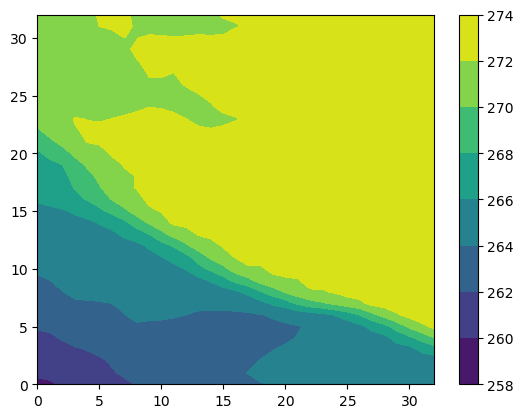

In [26]:
import matplotlib.pyplot as plt

#plt temp_ds

plt.contourf(temp_ds)
plt.colorbar()


In [28]:
tets = xr.open_dataset(f'/Users/fabienaugsburger/Documents/GitHub/master-project/climatology/test/{variable}/{variable}_{i+1}_{level}.nc')
tets

<xarray.Dataset>
Dimensions:                        (latitude: 721, longitude: 1440,
                                    coordinate: 167)
Coordinates:
  * latitude                       (latitude) float64 90.0 89.75 ... -90.0
  * longitude                      (longitude) float64 0.0 0.25 ... 359.5 359.8
    time                           (coordinate) datetime64[ns] ...
Dimensions without coordinates: coordinate
Data variables:
    __xarray_dataarray_variable__  (coordinate, latitude, longitude) float64 ...